# Title: Predicting Risk of Heart Disease Using Classification #
Group 14:
Jackie Hagstrom,
Hannah Reyes,
Mikayla Ditosto,
Minal Nijhawan 

# Introduction #
The theme of our project is heart disease, and we will be utilizing the data set sourced from the UC Irvine Machine Learning Repository. This data encompasses information from four distinct databases: Cleveland, Hungary, Switzerland, and VA Long Beach. Our study will concentrate on the Cleveland data set. This dataset classifies the presence of heart disease in a patient on a scale of 0-4 (0 implying the absence of risk, and 4 indicating the greatest presence).

Through this project, we are trying to answer the question: What variables can be used to classify a person’s risk of heart disease in Cleveland? Given that the response variable, num, is categorical, we will be solving this as a classification problem. There are a total of 14 different variables provided in the data set that can help detect the level of risk of heart disease in a patient. Please see the bottom of this document for the variable meanings.

# Preliminary exploratory data analysis #

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [6]:
# data was downloaded 
cleveland_data <- read_csv("https://raw.githubusercontent.com/mikayladitosto/dsci-100-2023s1-group-14/main/processed.cleveland.data", col_names = FALSE)
colnames(cleveland_data) <- c("age",
                              "sex",
                              "cp",
                              "trestbps",
                              "chol",
                              "fbs",
                              "restecg",
                              "thalach",
                              "exang",
                              "oldpeak",
                              "slope",
                              "ca",
                              "thal",
                              "num")
cleveland_data <- cleveland_data |>
    mutate(num = as_factor(num))
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


We downloaded the Cleveland data set and uploaded it to GitHub through our shared repository. After this step, we copied the URL into R, and we were able to read it with the read_csv function. Demonstrating that the dataset can be read from the web into R. 

In [49]:
num_obs <- nrow(cleveland_data)
cleveland_data |>
  group_by(num) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

num,count,percentage
<fct>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


This table shows us the number of observations in each category of heart disease. There is not an equal amount of people in each category, meaning our graphs can look disproportionate. During the classification analysis in our final project, we can make the classes proportionate by using class balancing to ensure the rarer classes are equally represented.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



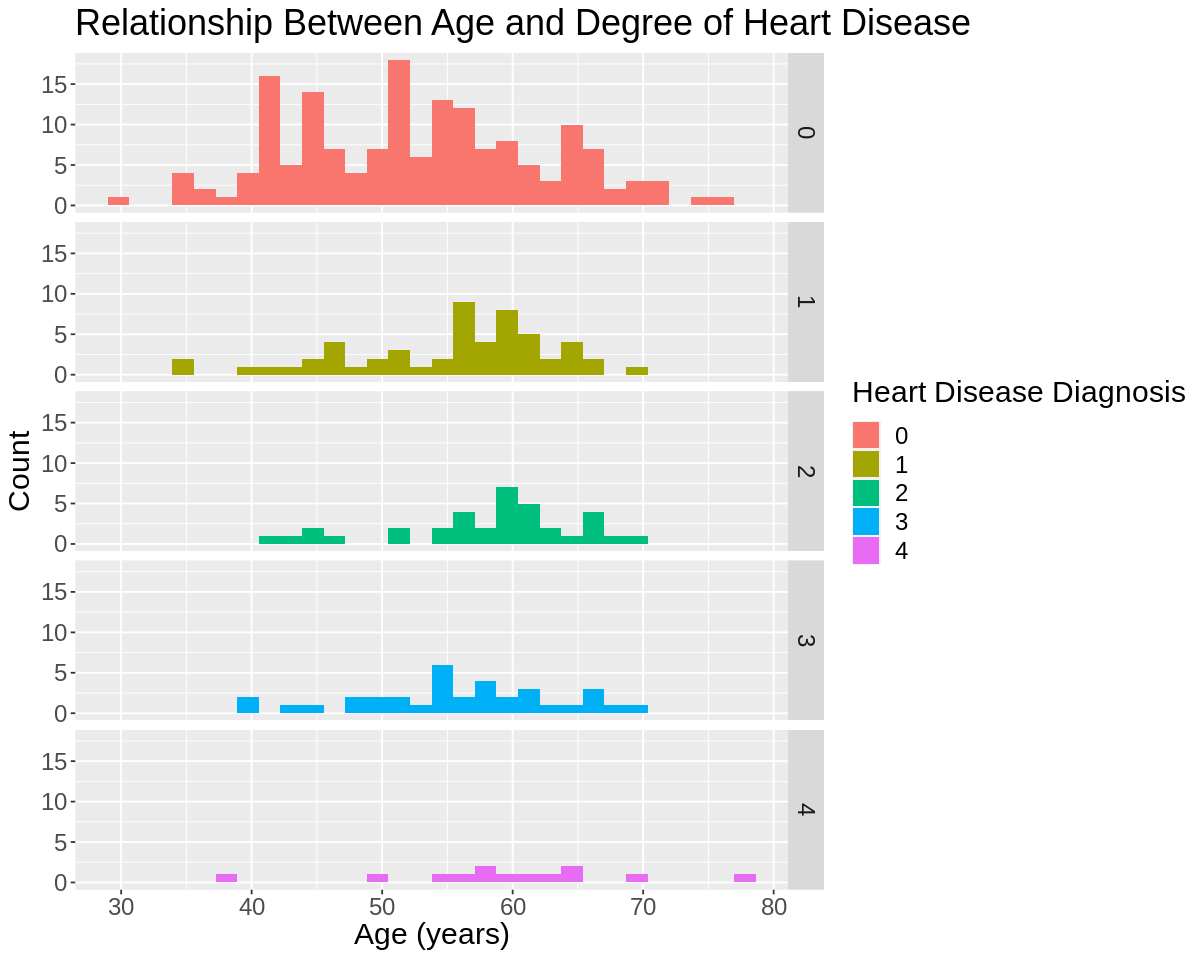

In [50]:
options(repr.plot.height = 8, repr.plot.width = 10)
age_hist <- ggplot(cleveland_data, aes(x = age, fill = num)) +
  geom_histogram(position = "identity") +
  facet_grid(rows = vars(num)) +
  labs(x = "Age (years)",
       y = "Count",
       fill = "Heart Disease Diagnosis") +
  ggtitle("Relationship Between Age and Degree of Heart Disease") +
  theme(text = element_text(size = 18))
age_hist

Based on the results from our histogram, it shows that there is no distinct relationship between age and num.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



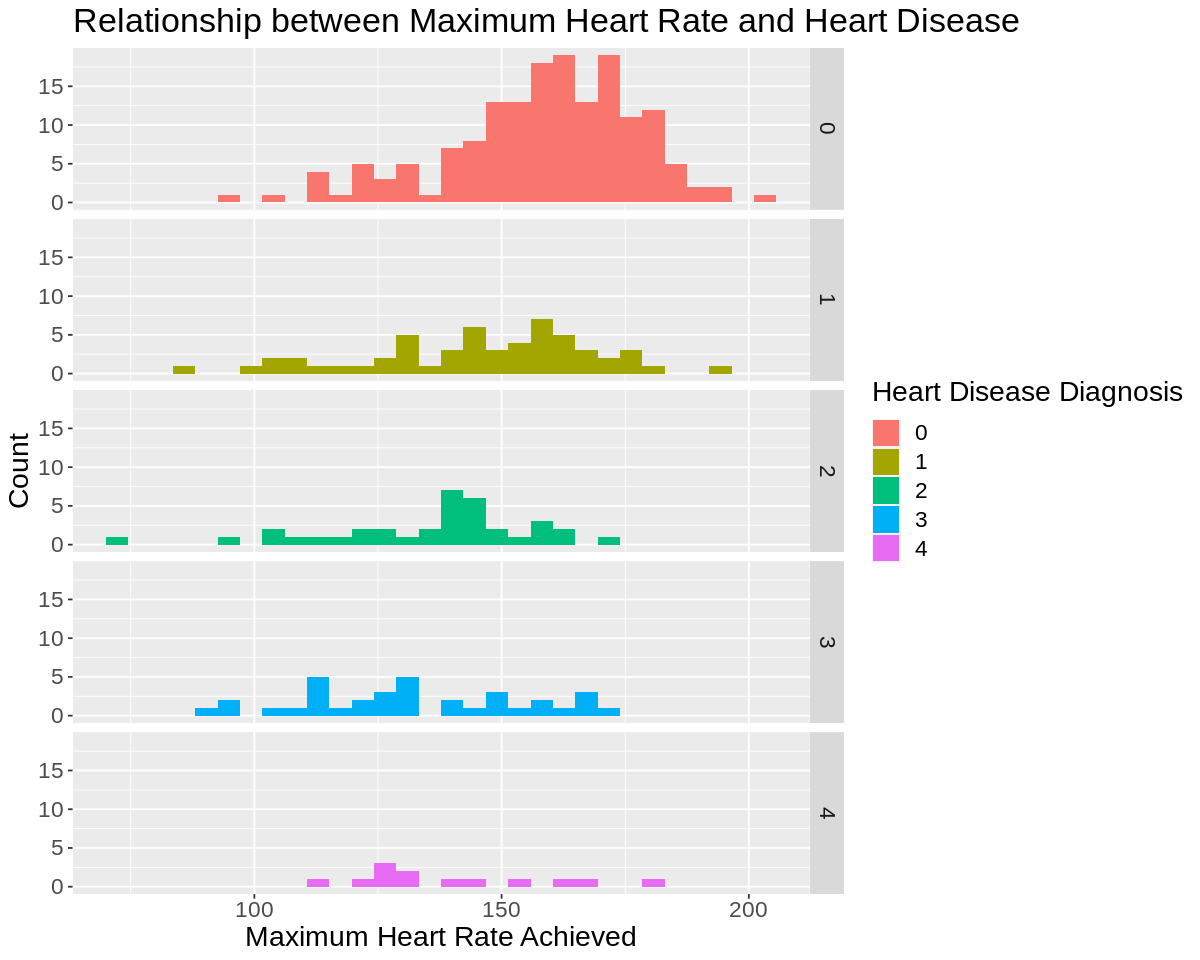

In [51]:
options(repr.plot.height = 8, repr.plot.width = 10)
thalach_plot <- cleveland_data |>
    ggplot(aes(x = thalach, fill = num)) +
    geom_histogram() +
    facet_grid(rows = vars(num)) +
    labs(x = "Maximum Heart Rate Achieved",
         y = "Count",
      fill = "Heart Disease Diagnosis") +
    theme(text = element_text(size = 17)) +
    ggtitle("Relationship between Maximum Heart Rate and Heart Disease")

thalach_plot

# Expected outcomes and significance #
From our research and findings, we expect that lower maximum heart rate (thalach) is a possible indicator/association for heart disease. We hope that our findings can validate other papers. The impact of these findings could influence the population of Cleveland to change certain practices according to our analysis. Future research related to heart disease could go down different paths, such as nutrition or  different lifestyle habits or practices. For example,  focus on different foods that help reduce cholesterol levels, which could potentially reduce heart disease. 

# Variables #
 1. (age) -> age in years
2. (sex) -> sex (1 = male; 0 = female)  
3. (cp) -> cp: chest pain type
4. (trestbps) -> resting blood pressure (in mm Hg on admission to the 
        hospital)
5. (chol) -> serum cholesterol in mg/dl
6. (fbs) -> (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. (restecg) -> resting electrocardiographic results
8. (thalach) -> maximum heart rate achieved
9. (exang) -> exercise induced angina 1= yes, 0= no
10. (oldpeak) -> ST depression induced by exercise relative to rest
11. (slope) ->  the slope of the peak exercise ST segment
 Value 1: upsloping
Value 2: flat
Value 3: downsloping
12. (ca) -> number of major vessels (0-3) colored by flourosopy
13. (thal) -> 3= normal, 6= fixed defect, 7= reversible defect
14. (num) -> (the predicted attribute) diagnosis of heart disease
Value 0: < 50% diameter narrowing
Value 1: > 50% diameter narrowing (in any major vessel)
